# Performance of Monte Carlo Tree Search for Fantasy Football drafts
My [blog post](https://medium.com/@ykeuter/performance-of-monte-carlo-tree-search-for-fantasy-football-drafts-269075d08088) about this notebook can be found on Medium.

In [1]:
class DraftState:
    def __init__(self, rosters, turns, freeagents, playerjm=None):
        self.rosters = rosters
        self.turns = turns
        self.freeagents = freeagents
        self.playerJustMoved = playerjm

In [2]:
class NflPlayer:
    def __init__(self, name, team, position, points):
        self.name = name
        self.team = team
        self.position = position
        self.points = points
        
    def __repr__(self):
        return "|".join([self.name, self.team, self.position, str(self.points)])

In [3]:
import numpy as np

def GetResult(self, playerjm):
    """ Get the game result from the viewpoint of playerjm.
    """
    if playerjm is None: return 0
    
    pos_wgts = {
        ("QB"): [.6, .4],
        ("WR"): [.7, .7, .4, .2],
        ("RB"): [.7, .7, .4, .2],
        ("TE"): [.6, .4],
        ("RB", "WR", "TE"): [.6, .4],
        ("D"): [.6, .3, .1],
        ("K"): [.5, .2, .2, .1]
    }

    result = 0
    # map the drafted players to the weights
    for p in self.rosters[playerjm]:
        max_wgt, _, max_pos, old_wgts = max(
            ((wgts[0], -len(lineup_pos), lineup_pos, wgts) for lineup_pos, wgts in pos_wgts.items()
                if p.position in lineup_pos),
            default=(0, 0, (), []))
        if max_wgt > 0:
            result += max_wgt * p.points
            old_wgts.pop(0)
            if not old_wgts:
                pos_wgts.pop(max_pos)
                
    # map the remaining weights to the top three free agents
    for pos, wgts in pos_wgts.items():
        result += np.mean([p.points for p in self.freeagents if p.position in pos][:3]) * sum(wgts)
        
    return result
        
DraftState.GetResult = GetResult

In [4]:
def GetMoves(self):
    """ Get all possible moves from this state.
    """
    pos_max = {"QB": 2, "WR": 6, "RB": 6, "TE": 2, "D": 2, "K": 1}

    if len(self.turns) == 0: return []

    roster_positions = np.array([p.position for p in self.rosters[self.turns[0]]], dtype=str)
    moves = [pos for pos, max_ in pos_max.items() if np.sum(roster_positions == pos) < max_]
    return moves

DraftState.GetMoves = GetMoves

In [5]:
def DoMove(self, move):
    """ Update a state by carrying out the given move.
        Must update playerJustMoved.
    """
    player = next(p for p in self.freeagents if p.position == move)
    self.freeagents.remove(player)
    rosterId = self.turns.pop(0)
    self.rosters[rosterId].append(player)
    self.playerJustMoved = rosterId
    
DraftState.DoMove = DoMove

In [6]:
def Clone(self):
    """ Create a deep clone of this game state.
    """
    rosters = list(map(lambda r: r[:], self.rosters))
    st = DraftState(rosters, self.turns[:], self.freeagents[:],
            self.playerJustMoved)
    return st

DraftState.Clone = Clone

In [7]:
# This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
# The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
# It aims to have the clearest and simplest possible code, and for the sake of clarity, the code
# is orders of magnitude less efficient than it could be made, particularly by using a 
# state.GetRandomMove() or state.DoRandomRollout() function.
# 
# Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
# 
# Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment
# remains in any distributed code.
# 
# For more information about Monte Carlo Tree Search check out our web site at www.mcts.ai

from math import *
import random

class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        UCTK = 200
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result


def UCT(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
    """

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []: # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m,state) # add child and descend tree

        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        while state.GetMoves() != []: # while state is non-terminal
            state.DoMove(random.choice(state.GetMoves()))

        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited

In [8]:
import pandas as pd

nfl_players = pd.read_csv("nfl_players.csv", index_col=0)
freeagents = [NflPlayer(*p) for p in nfl_players.itertuples(index=False, name=None)]

num_competitors = 10
rosters = [[] for _ in range(num_competitors)] # empty rosters to start with

num_rounds = 16
turns = []
# generate turns by snake order
for i in range(num_rounds):
    turns += reversed(range(num_competitors)) if i % 2 else range(num_competitors)
    
state = DraftState(rosters, turns, freeagents)

100
RB.RB.RB.RB.RB.RB.RB.RB.WR.WR.RB.RB.WR.WR.RB.WR.TE.RB.RB.TE.RB.TE.RB.WR.RB.RB.RB.RB.RB.RB.WR.RB.WR.WR.RB.RB.WR.RB.WR.WR.WR.WR.RB.RB.WR.RB.WR.WR.WR.WR.TE.TE.TE.WR.WR.WR.TE.WR.WR.RB.WR.WR.WR.WR.WR.WR.TE.WR.TE.TE.RB.WR.WR.D.RB.TE.WR.WR.WR.WR.QB.RB.WR.QB.QB.QB.TE.RB.K.RB.QB.WR.RB.WR.WR.RB.RB.TE.WR.WR.QB.QB.QB.RB.WR.TE.WR.TE.WR.QB.RB.WR.RB.WR.TE.RB.TE.TE.RB.QB.WR.WR.WR.WR.RB.TE.WR.WR.WR.QB.D.RB.QB.RB.TE.WR.QB.WR.D.RB.WR.WR.D.RB.RB.RB.RB.RB.RB.RB.TE.RB.RB.TE.RB.RB.RB.WR.RB.RB.D.K.QB.RB.RB.QB.D.D.RB.QB.RB.K.RB.QB.WR.QB.WR.QB.RB.RB.K.D.WR.WR.D.D.QB.D.WR.WR.WR.WR.QB.TE.QB.WR.D.WR.D.WR.QB.D.WR.TE.WR.D.D.RB.D.D.WR.D.D.WR.D.QB.RB.D.WR.K.QB.RB.WR.QB.K.WR.RB.D.RB.RB.D.RB.WR.K.D.WR.QB.K.K.D.TE.QB.RB.QB.D.RB.RB.QB.QB.K.QB.WR.WR.RB.QB.RB.D.RB.TE.WR.RB.QB.RB.WR.TE.RB.K.WR.K.WR.RB.TE.TE.WR.WR.WR.TE.RB.WR.WR.RB.RB.WR.D.WR.WR.WR.RB.TE.WR.WR.RB.WR.TE.WR.D.WR.TE.WR.WR.D.D.K.K.RB.K.WR.QB.D.QB.WR.D.QB.WR.TE.WR.RB.WR.WR.RB.200
RB.RB.RB.WR.RB.RB.WR.RB.RB.RB.RB.RB.RB.RB.RB.RB.WR.WR.WR.RB.RB.RB.TE.RB.WR.RB.WR.

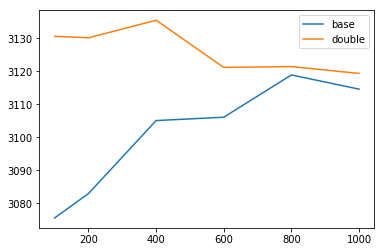

In [13]:
results = []
iterations = (100, 200, 400, 600, 800, 1000, 1200, 1400)
for it in iterations:
    state1 = state.Clone()
    state2 = state.Clone()
    print(it)
    while state1.GetMoves() != []:
        move1 = UCT(state1, it * (state1.turns[0] % 2 + 1))
        print(move1, end=".")
        state1.DoMove(move1)
        move2 = UCT(state2, it * ((state2.turns[0] + 1) % 2 + 1))
        print(move2, end=".")
        state2.DoMove(move2)
    results.append((state1, state2))

base_res = []
double_res = []
for state1, state2 in results:
    results1 = [sum(p.points for p in r) for r in state1.rosters]
    results2 = [sum(p.points for p in r) for r in state2.rosters] 
    results1 = np.reshape(results1, (-1, 2))
    results2 = np.reshape(results2, (-1, 2))
    base_res.append(np.mean(np.ravel(np.hstack((results1[:, 0], results2[:, 1])))))
    double_res.append(np.mean(np.ravel(np.hstack((results2[:, 0], results1[:, 1])))))

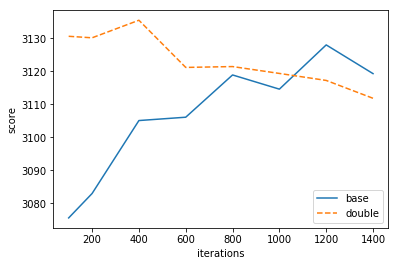

In [23]:
import matplotlib.pyplot as plt
    
fig, ax = plt.subplots()
ax.plot(iterations, base_res, label=f"base")
ax.plot(iterations, double_res, '--', label=f"double")
ax.set(xlabel="iterations", ylabel="score")
ax.legend()
fig.savefig("iterations.png")
plt.show()

In [40]:
def random_draft(state):
    return np.random.choice(state.GetMoves())

In [45]:
state1 = state.Clone()
state2 = state.Clone()
it = 1000
while state1.GetMoves() != []:
    if state1.turns[0] % 2:
        move1 = UCT(state1, it)
        move2 = random_draft(state2)
    else:
        move1 = random_draft(state1)
        move2 = UCT(state2, it)
    print(move1, end=".")
    state1.DoMove(move1)
    print(move2, end=".")
    state2.DoMove(move2)

results1 = [sum(p.points for p in r) for r in state1.rosters]
results2 = [sum(p.points for p in r) for r in state2.rosters] 
results1 = np.reshape(results1, (-1, 2))
results2 = np.reshape(results2, (-1, 2))
random_res = np.ravel(np.hstack((results1[:, 0], results2[:, 1])))
mcts_res = np.ravel(np.hstack((results2[:, 0], results1[:, 1])))

QB.RB.RB.QB.K.RB.RB.TE.QB.RB.RB.K.QB.WR.RB.D.RB.RB.WR.QB.RB.D.K.RB.WR.WR.RB.RB.WR.RB.QB.WR.WR.TE.QB.WR.RB.D.K.WR.WR.WR.WR.WR.QB.RB.RB.K.K.RB.RB.TE.K.RB.RB.RB.QB.RB.RB.TE.WR.TE.TE.WR.RB.K.QB.RB.WR.WR.RB.RB.WR.QB.TE.WR.WR.K.QB.WR.RB.RB.WR.QB.D.WR.WR.RB.RB.WR.WR.D.RB.WR.TE.RB.TE.WR.WR.D.TE.WR.RB.TE.WR.D.WR.TE.TE.WR.D.WR.TE.RB.TE.WR.WR.D.RB.WR.WR.TE.TE.TE.D.TE.WR.D.WR.QB.WR.RB.RB.WR.WR.QB.WR.WR.WR.RB.TE.K.QB.RB.RB.WR.WR.RB.RB.WR.RB.RB.RB.QB.WR.RB.RB.TE.WR.RB.WR.WR.TE.WR.WR.QB.D.D.WR.WR.D.TE.TE.WR.D.TE.RB.RB.RB.WR.D.WR.D.QB.RB.RB.RB.QB.WR.RB.WR.RB.WR.WR.RB.WR.D.RB.RB.QB.WR.RB.WR.WR.WR.RB.RB.WR.D.QB.D.D.D.D.WR.RB.RB.WR.QB.WR.RB.WR.D.QB.QB.WR.TE.RB.QB.RB.TE.D.QB.WR.WR.QB.QB.RB.D.QB.TE.WR.RB.WR.RB.WR.QB.WR.TE.TE.RB.RB.WR.QB.QB.TE.RB.WR.WR.WR.WR.RB.RB.D.WR.WR.D.WR.WR.WR.WR.WR.WR.RB.WR.D.WR.WR.WR.D.D.TE.K.WR.RB.K.TE.WR.RB.D.QB.QB.WR.TE.TE.QB.WR.TE.QB.QB.K.RB.WR.D.D.RB.RB.D.TE.RB.WR.TE.D.RB.RB.TE.QB.RB.TE.D.

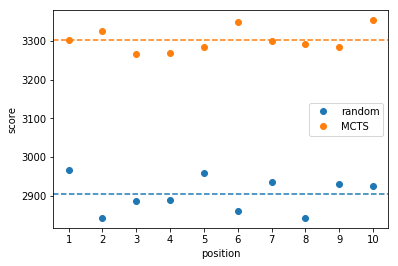

In [61]:
fig, ax = plt.subplots()
ax.plot([str(i + 1) for i in range(num_competitors)], random_res, 'o', label="random")
ax.axhline(np.mean(random_res), ls='--', c='tab:blue')
ax.plot([str(i + 1) for i in range(num_competitors)], mcts_res, 'o', label='MCTS')
ax.axhline(np.mean(mcts_res), ls='--', c='tab:orange')
ax.set(xlabel="position", ylabel="score")
ax.legend()
fig.savefig("random.png")
plt.show()

In [43]:
def greedy_draft(state):
    def result(move):
        st = state.Clone()
        st.DoMove(move)
        return st.GetResult(st.playerJustMoved)
    
    res, move = max((result(m), m) for m in state.GetMoves())
    return move

In [62]:
state1 = state.Clone()
state2 = state.Clone()
it = 1000
while state1.GetMoves() != []:
    if state1.turns[0] % 2:
        move1 = UCT(state1, it)
        move2 = greedy_draft(state2)
    else:
        move1 = greedy_draft(state1)
        move2 = UCT(state2, it)
    print(move1, end=".")
    state1.DoMove(move1)
    print(move2, end=".")
    state2.DoMove(move2)

results1 = [sum(p.points for p in r) for r in state1.rosters]
results2 = [sum(p.points for p in r) for r in state2.rosters] 
results1 = np.reshape(results1, (-1, 2))
results2 = np.reshape(results2, (-1, 2))
greedy_res = np.ravel(np.hstack((results1[:, 0], results2[:, 1])))
mcts2_res = np.ravel(np.hstack((results2[:, 0], results1[:, 1])))

D.RB.RB.D.D.RB.RB.D.QB.RB.RB.QB.QB.WR.WR.QB.QB.RB.RB.QB.RB.QB.QB.RB.RB.QB.QB.RB.WR.QB.QB.WR.WR.QB.QB.WR.RB.QB.QB.WR.QB.WR.WR.QB.QB.WR.RB.QB.K.RB.WR.K.K.RB.WR.K.K.RB.RB.K.TE.D.D.TE.RB.D.D.RB.RB.D.D.RB.WR.D.D.RB.RB.D.D.WR.K.RB.TE.K.K.WR.WR.K.D.TE.WR.D.D.TE.WR.D.D.WR.WR.D.WR.RB.WR.WR.TE.RB.WR.WR.TE.RB.WR.WR.TE.RB.WR.TE.RB.RB.WR.TE.WR.WR.RB.RB.RB.WR.WR.RB.WR.WR.WR.RB.RB.WR.WR.RB.WR.WR.RB.RB.TE.WR.WR.TE.TE.WR.RB.TE.TE.WR.WR.TE.TE.WR.RB.RB.TE.WR.RB.RB.RB.TE.WR.WR.WR.TE.RB.WR.TE.RB.RB.WR.WR.RB.RB.WR.TE.RB.RB.WR.RB.WR.WR.RB.WR.WR.WR.D.WR.WR.WR.RB.WR.WR.WR.WR.RB.WR.WR.WR.WR.RB.D.TE.TE.RB.QB.TE.TE.WR.QB.TE.TE.WR.QB.WR.TE.WR.D.TE.WR.WR.WR.QB.RB.RB.WR.QB.RB.WR.WR.QB.RB.WR.WR.D.WR.WR.RB.QB.RB.WR.QB.TE.RB.QB.QB.TE.WR.QB.QB.RB.RB.RB.QB.RB.WR.QB.WR.RB.K.RB.RB.WR.WR.TE.RB.WR.WR.RB.RB.WR.WR.RB.WR.WR.WR.RB.WR.D.WR.K.D.RB.RB.D.D.RB.RB.D.D.WR.WR.QB.D.WR.RB.D.QB.WR.QB.WR.RB.D.K.WR.WR.D.D.WR.RB.D.D.WR.WR.QB.QB.WR.TE.QB.

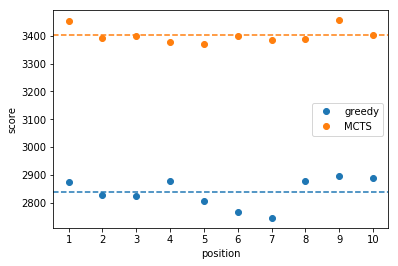

In [63]:
fig, ax = plt.subplots()
ax.plot([str(i + 1) for i in range(num_competitors)], greedy_res, 'o', label="greedy")
ax.axhline(np.mean(greedy_res), ls='--', c='tab:blue')
ax.plot([str(i + 1) for i in range(num_competitors)], mcts2_res, 'o', label='MCTS')
ax.axhline(np.mean(mcts2_res), ls='--', c='tab:orange')
ax.set(xlabel="position", ylabel="score")
ax.legend()
fig.savefig("greedy.png")
plt.show()

In [15]:
states = []
it = 1000
for i in range(20):
    st = state.Clone()
    while st.GetMoves() != []:
        move = UCT(st, it)
        print(move, end=".")
        st.DoMove(move)
    states.append(st)

RB.RB.RB.WR.RB.RB.RB.WR.WR.RB.RB.RB.RB.WR.RB.WR.RB.WR.TE.WR.WR.TE.RB.RB.WR.WR.WR.WR.TE.WR.WR.TE.WR.WR.RB.WR.WR.QB.QB.WR.TE.WR.WR.WR.TE.TE.RB.RB.QB.WR.QB.RB.TE.TE.RB.RB.QB.WR.RB.RB.WR.D.WR.WR.WR.TE.WR.WR.RB.WR.RB.RB.QB.RB.RB.RB.TE.RB.WR.RB.QB.WR.D.RB.QB.K.QB.RB.WR.WR.D.D.D.D.WR.D.D.QB.RB.D.K.QB.WR.QB.QB.D.D.K.RB.TE.RB.D.WR.WR.RB.WR.WR.RB.WR.WR.RB.RB.WR.RB.WR.QB.QB.QB.WR.QB.WR.WR.WR.WR.WR.RB.WR.TE.WR.TE.WR.K.K.TE.TE.QB.RB.RB.K.D.TE.QB.D.TE.D.D.D.TE.D.QB.RB.RB.RB.WR.RB.RB.RB.RB.RB.WR.RB.RB.WR.TE.WR.RB.RB.WR.WR.WR.WR.RB.RB.TE.WR.WR.TE.WR.WR.WR.WR.WR.WR.QB.WR.RB.TE.WR.WR.WR.TE.WR.WR.QB.TE.RB.WR.RB.WR.RB.TE.QB.QB.RB.TE.RB.RB.TE.QB.RB.WR.WR.WR.D.TE.WR.RB.WR.WR.WR.RB.RB.RB.RB.QB.RB.WR.RB.TE.RB.QB.RB.QB.WR.K.RB.WR.D.D.QB.D.WR.WR.D.D.QB.RB.D.D.D.WR.QB.QB.QB.D.K.D.K.TE.WR.RB.D.QB.QB.QB.WR.WR.WR.WR.RB.QB.RB.RB.RB.RB.WR.WR.WR.WR.WR.K.RB.RB.RB.WR.WR.WR.WR.WR.WR.K.TE.TE.K.QB.RB.WR.TE.QB.TE.D.TE.D.K.D.D.D.D.D.D.RB.RB.RB.WR.RB.RB.RB.TE.RB.RB.WR.WR.RB.RB.WR.RB.RB.WR.WR.WR.RB.WR.RB.WR.TE.WR.WR.TE.WR.WR.W

QB.TE.RB.RB.RB.WR.RB.RB.RB.RB.TE.WR.RB.RB.RB.RB.RB.WR.WR.WR.WR.WR.WR.RB.WR.RB.TE.WR.WR.WR.TE.WR.WR.WR.WR.RB.WR.TE.WR.WR.QB.WR.TE.WR.QB.TE.QB.WR.TE.WR.RB.RB.QB.QB.TE.RB.TE.RB.RB.RB.WR.RB.WR.WR.D.WR.RB.WR.RB.WR.K.WR.TE.RB.QB.TE.RB.RB.RB.WR.RB.RB.QB.D.RB.QB.WR.QB.RB.RB.RB.RB.D.WR.D.QB.D.D.D.QB.WR.D.WR.QB.WR.QB.K.WR.D.K.D.D.QB.QB.QB.WR.RB.D.WR.TE.RB.RB.QB.WR.RB.RB.WR.WR.WR.WR.WR.WR.RB.RB.WR.WR.TE.RB.WR.WR.TE.WR.TE.K.K.TE.WR.K.D.RB.WR.WR.TE.D.D.QB.QB.QB.D.TE.TE.D.RB.RB.RB.WR.RB.RB.RB.RB.TE.WR.RB.RB.RB.WR.RB.RB.WR.WR.WR.WR.WR.TE.WR.RB.RB.TE.WR.WR.WR.WR.WR.TE.WR.WR.TE.QB.WR.WR.TE.WR.RB.QB.RB.RB.TE.WR.RB.WR.QB.RB.WR.WR.QB.QB.D.RB.TE.TE.RB.WR.TE.WR.WR.WR.RB.QB.WR.WR.RB.RB.TE.WR.RB.RB.WR.K.RB.RB.WR.RB.QB.RB.D.QB.WR.WR.D.D.RB.D.QB.D.WR.WR.RB.WR.D.QB.D.D.D.K.QB.QB.D.QB.K.RB.D.WR.RB.WR.TE.RB.WR.RB.WR.WR.WR.WR.QB.QB.WR.WR.WR.RB.QB.WR.QB.WR.K.RB.TE.WR.WR.WR.RB.RB.WR.RB.WR.RB.TE.TE.TE.K.D.K.WR.D.QB.K.QB.TE.D.QB.D.RB.D.TE.

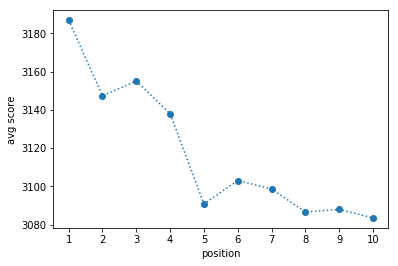

In [71]:
fig, ax = plt.subplots()
ax.plot([str(i + 1) for i in range(num_competitors)],
        np.mean([[sum(p.points for p in r) for r in s.rosters] for s in states], axis=0),
        ':o')
ax.set(xlabel="position", ylabel="avg score")
fig.savefig("position.png")
plt.show()